### Face Detection using PCA

Using PCA mechanism to correctly assign the face images to persons on the [Yale Face Dataset](https://vismod.media.mit.edu/vismod/classes/mas622-00/datasets/). Download the training data and testing data in this link.

#### Assignment 1 (4 scores): Implement PCA using Numpy.

In [1]:
pip install scikit-image

   ---------------------------------------- 0.0/11.9 MB ? eta -:--:--
    --------------------------------------- 0.3/11.9 MB ? eta -:--:--
   ------------------- -------------------- 5.8/11.9 MB 19.4 MB/s eta 0:00:01
   ---------------------------------------  11.8/11.9 MB 29.7 MB/s eta 0:00:01
   ---------------------------------------- 11.9/11.9 MB 16.8 MB/s  0:00:00
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 2.1/2.1 MB 23.9 MB/s  0:00:00

   ---------------------------------------- 0/5 [tifffile]
   ---------------------------------------- 0/5 [tifffile]
   ---------------------------------------- 0/5 [tifffile]
   ---------------------------------------- 0/5 [tifffile]
   ---------------------------------------- 0/5 [tifffile]
   ---------------------------------------- 0/5 [tifffile]
   ---------------------------------------- 0/5 [tifffile]
   ---------------------------------------- 0/5 [tifffile]
   --------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [60]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from skimage.io import imread
from skimage.transform import resize

In [61]:
# Principle Components Analysis
class PrincipleComponentAnalysis:
    def __init__(seft, n_components: int=1):
        seft.n_components = n_components
    
    def fit(self, X: np.ndarray):
        # tính ma trận hiệp phương sai
        cov = (X.T @ X)
        # tính giá trị và vector riêng
        eigenvalues, eigenvectors = np.linalg.eig(cov)
        # đưa các eigenvectors về cùng dấu dương
        for i in range (eigenvectors.shape[1]):
            if np.sign(np.sum(eigenvectors[:, i])) < 0:
                eigenvectors[:, i] *= -1
        # sắp xếp theo thứ tự giảm dần
        eigen_pairs = [(np.abs(eigenvalues[i]), eigenvectors[:,i]) for i in range(eigenvectors.shape[1])]  
        eigen_pairs.sort(key=lambda pair: pair[0], reverse=True)
        # chuyển về dạng ma trận
        eigenvalues = np.array([value for (value, _) in eigen_pairs])
        eigenvectors = np.array([vector for (_, vector) in eigen_pairs])
        # chọn thuộc tính
        self.principle_values = eigenvalues[:self.n_components]
        self._W = eigenvectors[:self.n_components]

    def transform(self, X: np.ndarray) -> np.ndarray:
        X_hat = self._W @ X
        return X_hat

#### Assignment 2 (4 scores):
- Reading the training images.
- Approximating the Principle Space having **20 dimensions**.
- Visualize the base of this Principle Space.

##### Reading the training images

In [62]:
BASE_DIR = "yalefaces"
person_folders = [
    "person-1",
    "person-2",
    "person-3",
    "person-4",
    "person-5",
    "person-6",
    "person-7",
    "person-8",
    "person-9",
    "person-10",
    "person-11",
    "person-12",
    "person-13",
    "person-14",
    "person-15"
]

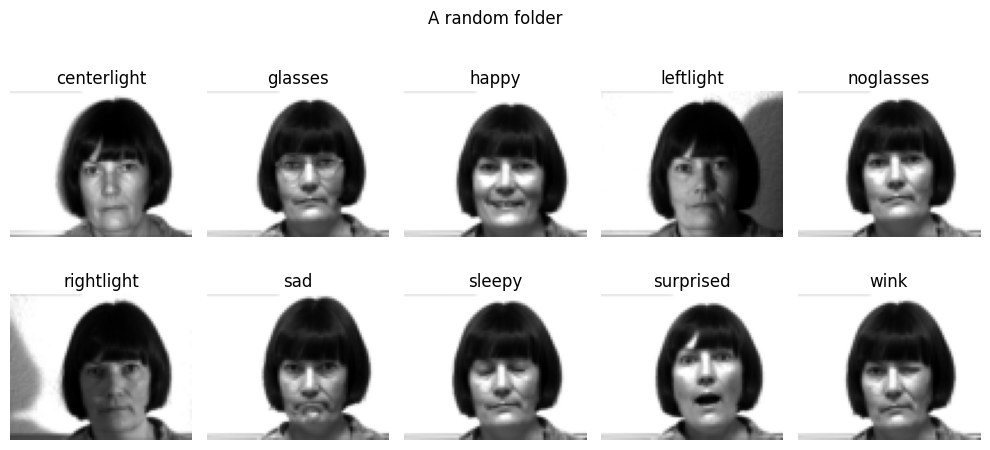

In [63]:
person_folder = random.choice(person_folders)
folder_path = os.path.join(BASE_DIR, person_folder)
plt.figure(figsize=(10,5))
for ith, filename in enumerate(os.listdir(folder_path)):
    img = imread(os.path.join(BASE_DIR, person_folder, filename))
    img = img.squeeze()
    img = resize(img, (64,80), anti_aliasing=True)
    plt.subplot(2, 5, ith+1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(filename)
plt.suptitle("A random folder")
plt.tight_layout()
plt.show()

In [64]:
data = {}
for person_folder in person_folders:
    for filename in os.listdir(os.path.join(BASE_DIR, person_folder)):
        img = imread(os.path.join(BASE_DIR, person_folder, filename))
        img = resize(img, (1, 64, 80), anti_aliasing=True)
        if person_folder not in data:
            data[person_folder] = [img]
        else:
            data[person_folder].append(img)
            
for person in data:
    data[person] = np.concat(data[person], axis=0).reshape(10, -1)

##### Approximating the Principle Space having 20 dimensions

In [65]:
PCA = PrincipleComponentAnalysis(n_components=20)
# chuẩn hóa ảnh
def standardizing_img(img:np.ndarray) -> np.ndarray:
    img = (img - img.mean()) / img.std()
    img = img.astype(np.float32)
    return img

imgs = []
for person in data:
    imgs.append(data[person])
imgs = np.concat(imgs, axis=0)
imgs = standardizing_img(imgs)
imgs.shape

(150, 5120)

In [66]:
PCA.fit(imgs)
PCA._W.shape

(20, 5120)

##### Visualize the base of this Principle Space

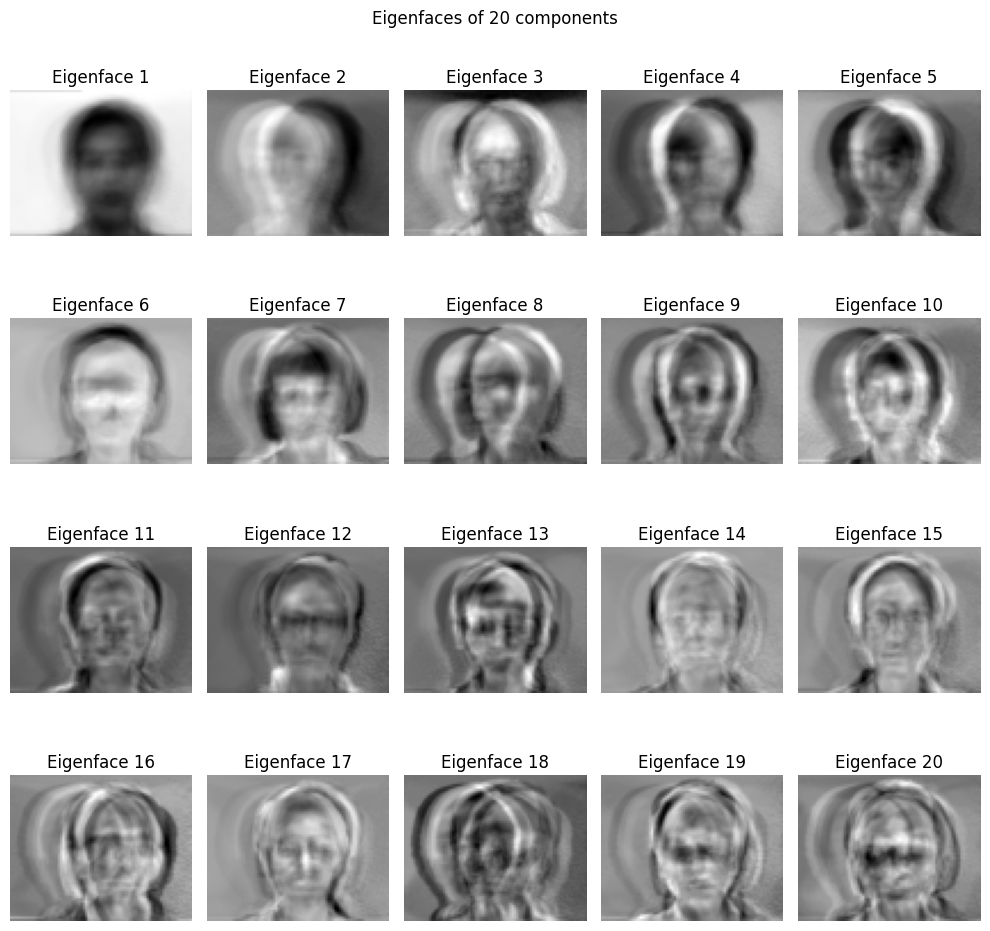

In [67]:
eigenfaces = PCA._W
eigenfaces = eigenfaces.reshape(20, 64, 80)
plt.figure(figsize=(10, 10))
for ith, eigenface in enumerate(eigenfaces):
    plt.subplot(4,5,ith+1)
    plt.imshow(eigenface, cmap="gray")
    plt.axis("off")
    plt.title(f"Eigenface {ith+1}")
plt.suptitle("Eigenfaces of 20 components")
plt.tight_layout()
plt.show()

#### Assignment 3 (2 scores): 
- Assign persons to the face images in testing data.
- Evaluate the accuracy of this face recognition system.

##### Assign persons to the face images in testing data

In [68]:
mean_faces = {person: np.mean(img, axis=0) for person, img in data.items()}

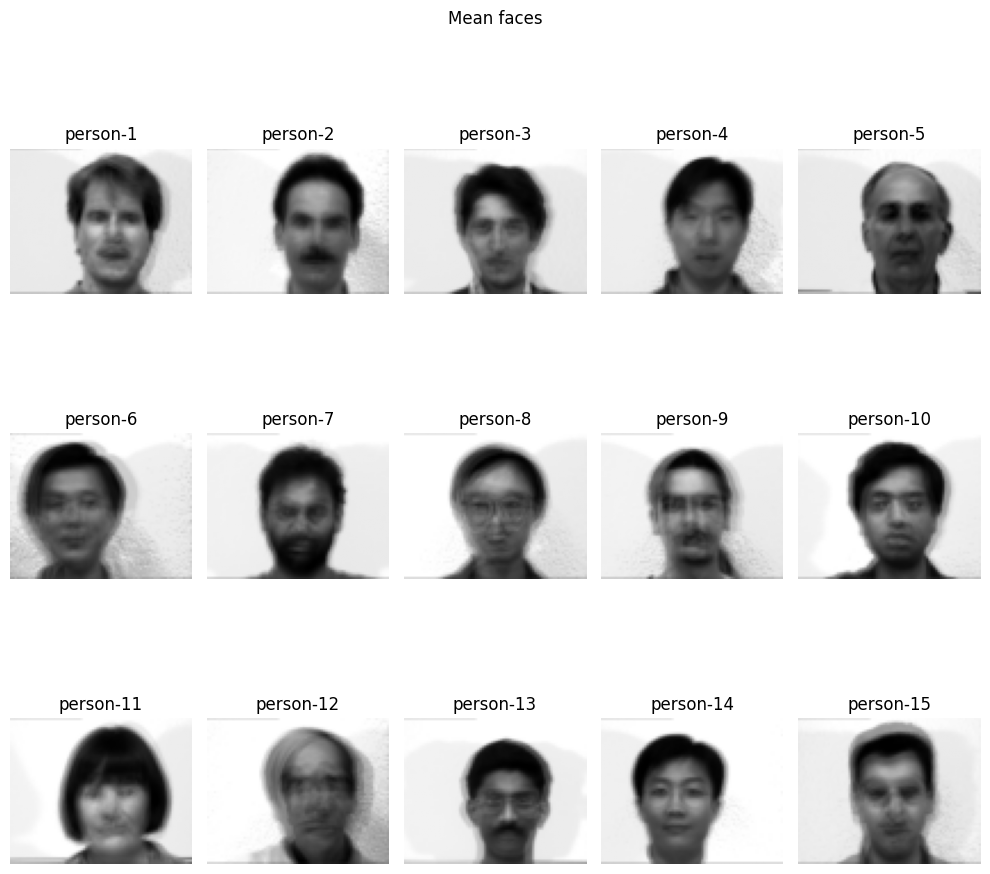

In [69]:
plt.figure(figsize=(10, 10))
for ith, person in enumerate(mean_faces):
    mean_face = mean_faces[person]
    mean_face = mean_face.reshape(64, 80)
    plt.subplot(3, 5, ith+1)
    plt.imshow(mean_face, cmap="gray")
    plt.axis("off")
    plt.title(person)
plt.suptitle("Mean faces")
plt.tight_layout()
plt.show()

In [70]:
pca_mean_faces = {}
for person in mean_faces:
    pca_mean_faces[person] = PCA.transform(mean_faces[person])

In [71]:
# Loading test data
labels = []
test_img = []
TEST_DIR = "yalefaces/test"
for filename in os.listdir(os.path.join(TEST_DIR)):
    person_name = filename.split(".")[0]
    labels.append(person_name)
    img = imread(os.path.join(TEST_DIR, filename))
    img = resize(img, (1, 64, 80), anti_aliasing=True)
    test_img.append(img)

In [72]:
test_img = np.concat(test_img, axis=0)
test_img.shape

(15, 64, 80)

In [73]:
labels

['person-1',
 'person-10',
 'person-11',
 'person-12',
 'person-13',
 'person-14',
 'person-15',
 'person-2',
 'person-3',
 'person-4',
 'person-5',
 'person-6',
 'person-7',
 'person-8',
 'person-9']

In [74]:
def Euclide_distance(X: np.ndarray, Y: np.ndarray):
    assert X.shape == Y.shape, f"{X.shape} and {Y.shape} are miss-shaped"
    return (((X-Y)**2).sum())**0.5

In [75]:
predict = {}
for label, img in zip(labels, test_img):
    img = img.reshape(-1)
    closet_distance = np.inf
    closet_person = None
    for person in pca_mean_faces:
        distance = Euclide_distance(PCA.transform(img), pca_mean_faces[person])
        if distance < closet_distance:
            closet_distance = distance
            closet_person = person

    predict[label] = closet_person

##### Evaluate the accuracy of this face recognition system

In [76]:
EMs = []
for label in predict:
  EMs.append(label == predict[label])
print(f"Correct: {sum(EMs)}")
print(f"Incorrect: {len(EMs) - sum(EMs)}")
print(f"Accurary: {(np.mean(EMs)*100):0.2f}%")

Correct: 10
Incorrect: 5
Accurary: 66.67%
